In [1]:
import sys
sys.path.append("../src")
from utils import *

In [2]:
sc.set_figure_params(dpi=100)
sns.set(style="ticks")

In [3]:
import matplotlib
from matplotlib import font_manager
font_dirs = "/usr/share/fonts/truetype/msttcorefonts/"
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

matplotlib.pyplot.rcParams['font.family'] = "arial"

In [4]:
adata_ctrl1 = sc.read(os.path.join(datadir, "internal_ctrl_samples_processed.h5ad"))
adata_ctrl2 = sc.read(os.path.join(datadir, "external_ctrl_samples_processed.h5ad"))

In [5]:
adata_anca = sc.read(os.path.join(datadir, "anca_samples_annotated_v2.h5ad"))

In [6]:
geneset1 = adata_anca.var.loc[adata_anca.var["highly_variable"]].index.tolist()
geneset1 = [gene for gene in geneset1 if gene in adata_ctrl1.var_names]

geneset2 = adata_anca.var.loc[adata_anca.var["highly_variable"]].index.tolist()
geneset2 = [gene for gene in geneset2 if gene in adata_ctrl2.var_names]

In [7]:
df = pd.DataFrame(index=adata_anca.var.index, columns=["mean", "stddev"])
adata_anca.var["mean"] = adata_anca.to_df().mean()
adata_anca.var["std"] = adata_anca.to_df().std()

In [8]:
import symphonypy as sp

In [9]:
sp.pp.harmony_integrate(adata_anca, key="Sample")

2023-11-29 10:39:29,957 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-11-29 10:39:33,010 - harmonypy - INFO - sklearn.KMeans initialization complete.


In [10]:
tmp1 = adata_ctrl1[:, geneset1]
sp.tl.map_embedding(tmp1, adata_anca, key="Sample")
sp.tl.per_cell_confidence(tmp1, adata_anca)

tmp2 = adata_ctrl2[:, geneset2]
sp.tl.map_embedding(tmp2, adata_anca, key="Sample")
sp.tl.per_cell_confidence(tmp2, adata_anca)

38 out of 1372 genes from the reference are missing in the query dataset or have zero std in the reference, their expressions in the query will be set to zero


In [11]:
sc.pp.neighbors(adata_anca, use_rep="X_pca_harmony")
sc.tl.umap(adata_anca)

In [12]:
sp.tl.transfer_labels_kNN(tmp1, adata_anca, "cluster_annot")
sp.tl.transfer_labels_kNN(tmp2, adata_anca, "cluster_annot")

In [13]:
sp.tl.ingest(tmp1, adata_anca)
sp.tl.ingest(tmp2, adata_anca)

In [14]:
adata_ctrl1.obsm["X_umap"] = tmp1.obsm["X_umap"].copy()
adata_ctrl2.obsm["X_umap"] = tmp2.obsm["X_umap"].copy()

adata_ctrl1.obs["cluster_annot"] = tmp1.obs["cluster_annot"].copy()
adata_ctrl2.obs["cluster_annot"] = tmp2.obs["cluster_annot"].copy()

In [15]:
adata_combined = adata_ctrl1.concatenate([adata_ctrl2, adata_anca], uns_merge="unique")

/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [16]:
adata_combined.obs["cluster_annot"] = adata_combined.obs["cluster_annot"].astype("category")

In [17]:
import pickle
with open(os.path.join(datadir, "cluster_annot_colors.pkl"), "rb") as f:
    colors_dict = pickle.load(f)
    
colors = []
for clst in adata_combined.obs["cluster_annot"].cat.categories:
    colors.append(colors_dict[clst])
adata_combined.uns["cluster_annot_colors"] = colors

In [18]:
external_samples = ["M61", "F52", "M32", "21-019", "21-015"]

In [19]:
external_samples

['M61', 'F52', 'M32', '21-019', '21-015']

In [20]:
adata_combined.obs["Cohort"] = "Internal"
adata_combined.obs.loc[adata_combined.obs.Sample.isin(external_samples), "Cohort"] = "External"

In [21]:
tab = pd.crosstab(adata_combined.obs["Condition"], adata_combined.obs["cluster_annot"])
tab = tab.div(tab.sum(1),0)*100

row_order = ["CTRL", "ANCA"]
col_order = ["PT", "PT/DCT", "DCT/CNT", "CNT/PC", "CNT/PC/IC", "PT/LOH", "LOH",
         "Tubulointerstitial", "Vasculature", "Normal glomerular", "Inflamed glomerular", "Inflamed tubulointerstitial"]

In [22]:
import pickle
with open(os.path.join(datadir, "cluster_annot_colors.pkl"), "rb") as f:
    colors_dict = pickle.load(f)

In [23]:
for col in col_order:
    if col not in tab.columns:
        tab[col] = 0

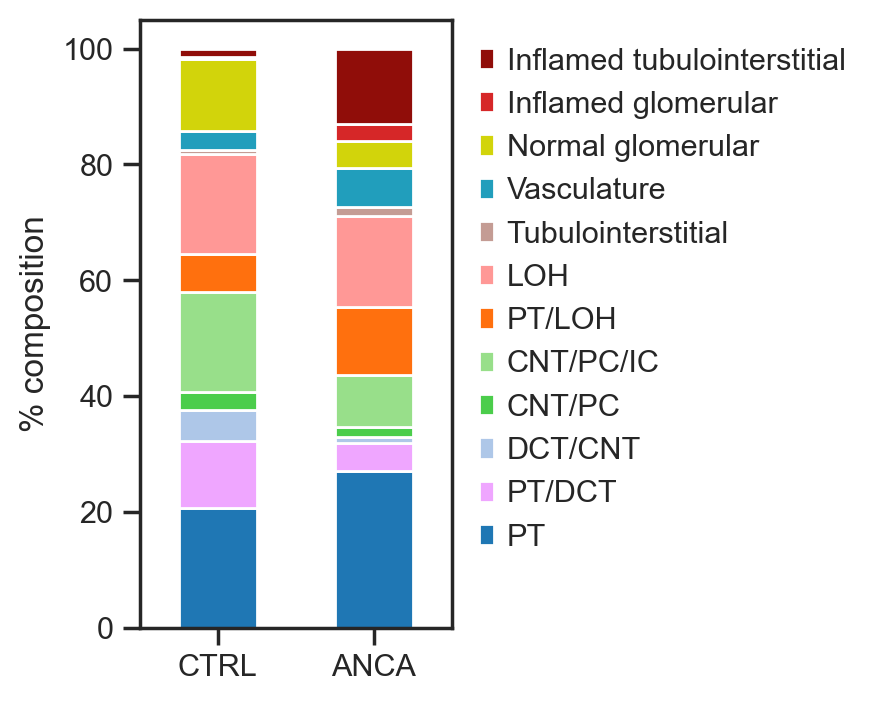

In [24]:
ax = tab.loc[row_order, col_order].plot(kind="bar", stacked=True, figsize=(2,4), color=colors_dict)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,1), frameon=False)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel("% composition")

plt.savefig(os.path.join(figdir, "BARPLOT_ctrls_vs_anca_coloredByCluster_annot.pdf"), bbox_inches="tight")

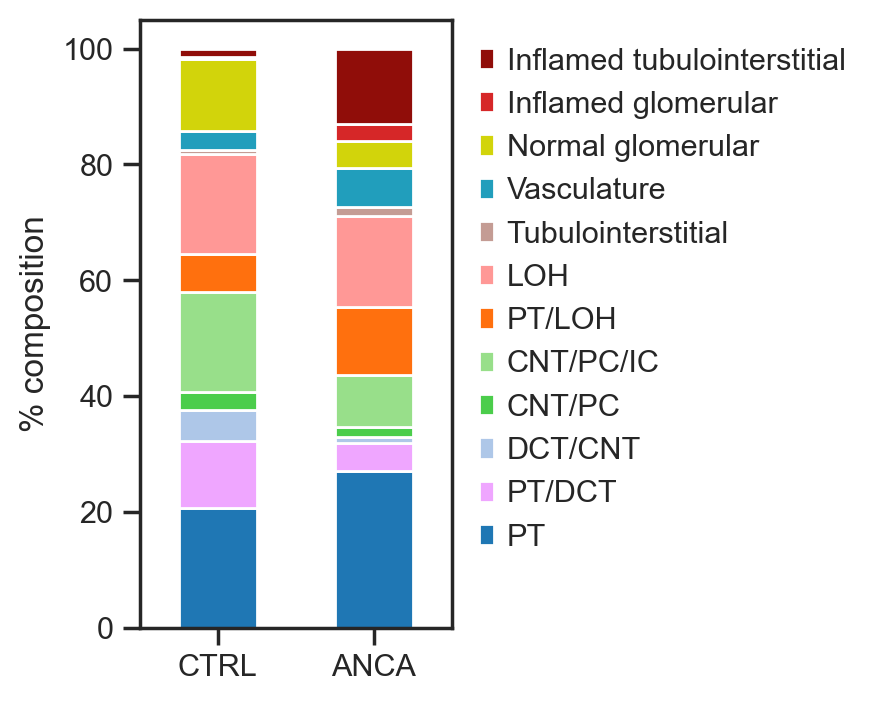

In [25]:
ax = tab.loc[row_order, col_order].plot(kind="bar", stacked=True, figsize=(2,4), color=colors_dict)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,1), frameon=False)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel("% composition")

plt.savefig(os.path.join(figdir, "BARPLOT_ctrls_vs_anca_coloredByCluster_annot.pdf"), bbox_inches="tight")

# merge

In [ ]:
keep_clusters = ["Normal glomerular", "Inflamed glomerular", "Tubulointerstitial", "Tubulonterstitial/Vessels", 
                 "Inflamed tubulointerstitial"]
tubule_clusters = []
for cluster in adata_combined.obs.cluster_annot.unique():
    if cluster not in keep_clusters:
        tubule_clusters.append(cluster)
broad_mapping = dict(zip(tubule_clusters, ["Tubules"]*len(tubule_clusters)))

In [ ]:
adata_combined.obs["cluster_annot_broad"] = adata_combined.obs["cluster_annot"].replace(broad_mapping)

In [ ]:
tab = pd.crosstab(adata_combined.obs["Condition"], adata_combined.obs["cluster_annot_broad"])
tab = tab.div(tab.sum(1),0)*100

row_order = ["CTRL", "ANCA"]
col_order = ["Tubules", "Tubulointerstitial", "Tubulointerstitial/Vessels", "Normal glomerular", "Inflamed glomerular", 
             "Inflamed tubulointerstitial"]

In [ ]:
with open(os.path.join(datadir, "cluster_annot_broad_colors.pkl"), "rb") as f:
    colors_dict = pickle.load(f)

In [ ]:
for col in col_order:
    if col not in tab.columns:
        tab[col] = 0

In [ ]:
with open(os.path.join(datadir, "cluster_annot_broad_colors.pkl"), "rb") as f:
    colors_dict = pickle.load(f)
    
colors = []
for clst in adata_combined.obs["cluster_annot_broad"].cat.categories:
    colors.append(colors_dict[clst])
adata_combined.uns["cluster_annot_broad_colors"] = colors

In [ ]:
ax = tab.loc[row_order, col_order].plot(kind="bar", stacked=True, figsize=(2,4), color=colors_dict)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,1), frameon=False)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel("% composition")

plt.savefig(os.path.join(figdir, "BARPLOT_ctrls_vs_anca_coloredByCluster_annot_broad.pdf"), bbox_inches="tight")

In [ ]:
sc.pl.umap(adata_combined, color=["Cohort", 
                                  "Condition", "cluster_annot",  "cluster_annot_broad"], 
           wspace=0.5, title=["Cohort", "Condition", "Cluster", "Cluster (merged)"], show=False, ncols=2)
plt.savefig(os.path.join(figdir, "UMAP_all_samples_coloredByCohort_Condition_Cluster_annot_Cluster_annot_broad.pdf"), bbox_inches="tight")
plt.clf()

In [ ]:
adata_combined.write(os.path.join(datadir, "all_samples_clustered.h5ad"))

In [ ]:
adata = sc.read(os.path.join(datadir, "all_samples_clustered.h5ad"))

In [ ]:
adata = adata[adata.obs["Sample"]!="CTRL1_A"]

In [ ]:
pd.crosstab(adata.obs.Condition, adata.obs.Cohort)

In [ ]:
tab = pd.crosstab(adata.obs.Condition, adata.obs.cluster_annot)
tab = tab.div(tab.sum(1),0)

In [ ]:
tab

In [ ]:
adata.obs.Condition.value_counts()

In [ ]:
import symphonypy
symphonypy.__version__